# Baseline

# Imports and Installation

In [2]:
import sys

In [3]:
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install chart_studio
!{sys.executable} -m pip install kaleido
!{sys.executable} -m pip install torch torchvision

     |████████████████████████████████| 64 kB 2.7 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=379d5ec6c15eff176070f4e3d19cbd48f0c825fabb32390290d3d846d9d70c74
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
     |████████████████████████████████| 79.9 MB 130 kB/s 


In [4]:
import os
import sys
import csv
import torch
import torchvision
from torch import nn
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from sklearn import metrics
import plotly
import kaleido
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          'axes.titlecolor': 'w',
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)
import plotly.graph_objects as go
import plotly.offline as offline

# Dataset
Our dataset is going to be based off of the PNG representation of the flight, from a top down perspective.

Images will be saved to `{path}_img` folder.

You can modify this `Dataset` class to fit your needs.

In [31]:
import plotly.express as px
class FlightsAsImageDataset(torch.utils.data.Dataset):
    def __init__(self, path, size=128, make=True, dropnan=True):
        """
        DESC
        ---
        Initializes a Dataset class for the maneuver-id data. Reads the data
        from .tsv files convert all flights to graphs as a png file. The graphs are 
        based on 'xEast' and 'yNorth' and represent a top-down view of the flight.
        ---
        INPUTS
        ---
        path - folder path that includes the two subdirectories called
        'good' and 'bad'. These directories should include only .tsv files
        size - the height and width of the output .png
        make - whether or not to generate the image (false allows you to skip 
        making the image if it already exists)
        dropnan - whether or not to drop the files with NaN after normalizing
        features in the data
        ---
        RETURN
        ---
        __FlightsAsImageDataset instance
        """

        self.all_labels = [folder for folder in os.listdir(path)]
        self.images = []
        self.labels = []
        self.size = size
        self.png_path = 'flights/imgs/'
        self.good_paths = os.listdir('flights/imgs/good/')
        self.bad_paths = os.listdir('flights/imgs/bad/')
        self.nan_good_count = 0
        self.nan_bad_count = 0
        i = 1
        
        self.folder_names = ['good', 'bad']
        i = 0
        # iterate through the two folders
        for folder_name in self.folder_names:
            # iterate through the .tsv files in the two folders
            for file_name in os.listdir(os.path.join(path, folder_name)):
                i += 1
                # join path and read the tsv
                if i%100==0:
                  print(i, "files completed")
                data_path = os.path.join(path, folder_name, file_name)
                if dropnan == True:
                  X = pd.read_csv(data_path, sep = '\t', index_col=0)

                  # drop two unecessary columns
                  X = X.drop(columns=['time (sec)'])
                  X = (X - X.mean()) / X.std()
                  X = X.to_numpy(dtype='float32')

                  # check for nan
                  if np.isnan(X).any():
                    if folder_name == 'good':
                      self.nan_good_count += 1
                    else:
                      self.nan_bad_count += 1
                    continue

                new_path = self.convert_to_png(data_path, folder_name, make)

                self.images.append(new_path)
                self.labels.append(folder_name)

        #print("NAN good count = ", self.nan_good_count)
        #print("NAN bad count = ", self.nan_bad_count)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        path = self.images[idx]
        #print(path)
        img = Image.open(path).convert('RGB')
        array = np.array(img)
        label = self.labels[idx]
        if label == "good":
            label = 1
        else:
            label = 0
        label = torch.tensor(label, dtype=torch.float32)
        tensor = torchvision.transforms.ToTensor()(img)
        return tensor, label.long()
    
    def convert_to_png(self, full_path, label, make):
        folder = os.path.dirname(full_path)
        file_name = os.path.basename(full_path)
        os.makedirs(folder, exist_ok=True)
        png_name = file_name.replace('.tsv', '.png')
        check_path = os.path.join(self.png_path+label, png_name)

        if check_path[18:] in self.good_paths or check_path[17:] in self.bad_paths:
          #print("Already exists, returning")
          return check_path
      
        # print(full_path)
        new_path = check_path
        
        if make:
            data = self.load(full_path)
            y = [row["yNorth (m)"] for row in data]
            x = [row["xEast (m)"] for row in data]
            plot = go.Scatter(
                x=x, 
                y=y,
                marker=dict(
                    size=2,
                    color="black"
                ),
                line=dict(
                    color='black',
                    width=2
                )
            )
            fig = go.Figure(data=plot)
            fig.update_layout(
                margin=go.layout.Margin(
                    l=0, #left margin
                    r=0, #right margin
                    b=0, #bottom margin
                    t=0, #top margin
                ),
                height=self.size,
                width=self.size,
                scene=dict(
                    camera=dict(
                        up=dict(
                            x=0,
                            y=0,
                            z=1
                        ),
                        eye=dict(
                            x=0,
                            y=1.0707,
                            z=1,
                        )
                    ),
                    aspectratio = dict( x=1, y=1, z=0.7 ),
                    aspectmode = 'manual'
                ),
            )
            fig.update_xaxes(showticklabels=False, showgrid=False)
            fig.update_yaxes(showticklabels=False, showgrid=False)
            fig.write_image(new_path)
        return new_path

    @staticmethod
    def clean_row(row):
        output = {}
        for header in row:
            value = row[header]
            try:
                output[header.strip()] = float(value)
            except:
                return False
        return output
        
    def load(self, full_path):
        output = []
        with open(full_path) as incoming:
            reader = csv.DictReader(incoming, delimiter='\t')
            for row in reader:
                cleaned_row = self.clean_row(row)
                if cleaned_row:
                    output.append(cleaned_row)
        return output

In [ ]:
train_path = 'flights/tsv/'
dataset = FlightsAsImageDataset(train_path)
print("Size of dataset", len(dataset))
#print("NAN count = ", dataset.nan_count)

# Train, Val, Test Split

In [34]:
train_percentage = 0.50
val_percentage   = 0.25
# test percentage is inferred
batch_size = 1
N = len(dataset) 
train_size = int(N * train_percentage)
val_size = int(N * val_percentage)
test_size = N - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle=False)

# Making A Model
Now we'll write a convolutional neural network (CNN) based on graphs of the `xEast` and `yNorth` fields (it will visualize as though we were looking at the flight path from a top-down perspective) to see if it can classify the flights in accordance with the labled data.

---

**Caveat**

In order to accomplish this part of the notebook, you will have have to have access to the dataset.

---

## Building The Model
Here we'll build a CNN to train on our dataset.

In [35]:
# 3rd party
from torch import nn

class CNN(nn.Module):
    """
    A basic convolutional neural network
    """
    def __init__(self):
        
        super(CNN, self).__init__()
        
        # reused
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = torch.flatten
        self.relu = nn.ReLU()
        
        # layer one
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # layer two
        self.conv2 = nn.Conv2d(6, 12, 5)
        
        # connected layers
        self.linear1 = nn.Linear(10092, 512)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 1)
        
    def forward(self, x):
        # first set of layers
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.relu(x)
        #print(x.shape)
        x = self.pool(x)
        
        
        # second set of layers
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # connected
        x = torch.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        x = self.relu(x)
        
        x = self.linear3(x)
        
        return x

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
model = CNN().to(device)

Using cuda device


In [37]:
print(model)

CNN(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (linear1): Linear(in_features=10092, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
)


## Training the Model
Here we'll do 5 passes at training the model, saving the best models.

In [38]:
def train_one_epoch(model, data, loss, optimizer):
    """
    DESC
    ---
    Trains the given model for 1 epoch on the training data, 
    computes the loss and gradients with criterion and optimizer.
    ---
    INPUTS
    ---
    model - CNN model
    data - the train dataloader 
    criterion - loss function such as CrossEntropyLoss
    optimizer - optimizer module such as SGD or AdamW
    ---
    RETURN
    ---
    None
    """
    total_loss = 0.
    model.train()
    i = 0
    for img, label in data:
        pred_label = model(img.to(device))
        l = loss(pred_label, label.float().to(device))
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += l.item()
        i += 1
        # if i % 500 == 0:
        #     print(f'train: img {i} avg loss - {total_loss / i}')
    return total_loss / len(data)


def test_one_epoch(model, data, loss):
    """
    DESC
    ---
    Evaluates the given model for 1 epoch on the validation data
    computes the loss.
    ---
    INPUTS
    ---
    model - CNN model
    data - the validation dataloader 
    criterion - loss function such as CrossEntropyLoss
    optimizer - optimizer module such as SGD or AdamW
    ---
    RETURN
    ---
    Loss - validation loss
    """
    total_loss = 0.
    model.eval()
    i = 0
    for img, label in data:
        pred_label = model(img.to(device))
        l = loss(pred_label, label.to(device))
        total_loss += l.item()
        i += 1
        # if i % 100 == 0:
        #     print(f'validate: img {i} avg loss - {total_loss / i}')
    return total_loss / len(data)

In [39]:
epochs = 50
learning_rate = 0.01

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [40]:
best_loss = None
print(f'training size - {len(train_loader)} validate size - {len(val_loader)}')
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, loss, optimizer)
    val_loss = test_one_epoch(model, val_loader, loss)
    print(f'{epoch + 1}: train - {train_loss:.7f} test - {val_loss:.7f}')
    if best_loss is None or val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

training size - 3013 validate size - 1506
1: train - 0.0641260 test - 0.0424363
2: train - 0.0493930 test - 0.0537030
3: train - 0.0390057 test - 0.0317752
4: train - 0.0269219 test - 0.0204663
5: train - 0.0246946 test - 0.0207523
6: train - 0.0204016 test - 0.0207695
7: train - 0.0176448 test - 0.0248117
8: train - 0.0152623 test - 0.0194041
9: train - 0.0131085 test - 0.0230734
10: train - 0.0104768 test - 0.0173517
11: train - 0.0082556 test - 0.0165262
12: train - 0.0067580 test - 0.0157282
13: train - 0.0058993 test - 0.0153748
14: train - 0.0065014 test - 0.0185674
15: train - 0.0050351 test - 0.0163652
16: train - 0.0041146 test - 0.0151432
17: train - 0.0034867 test - 0.0145640
18: train - 0.0032548 test - 0.0177176
19: train - 0.0027896 test - 0.0146718
20: train - 0.0024880 test - 0.0153140
21: train - 0.0024776 test - 0.0154413
22: train - 0.0023428 test - 0.0144391
23: train - 0.0020940 test - 0.0145248
24: train - 0.0021174 test - 0.0145694
25: train - 0.0019356 test - 0.

# Model Evaluation
Next we'll check the overall accuracy of the model on our testing data.

In [41]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [42]:
correct = 0
# Regression
for img, label in test_loader:
    model.eval()
    pred = model(img.to(device))
    rounded_pred = round(pred.item())
    if rounded_pred == label:
        correct += 1
print(f'{(correct / len(test_loader)) * 100:.4f}% correct')

98.4085% correct


## Precision, Recall, F1 Score and Confusion Matrix

In [45]:
y_true = []
y_pred = []
for i, (img, label) in enumerate(test_loader):
    model.eval()
    pred = model(img.to(device))
    prediction = round(pred.item())
    ground_truth = label.item()
    y_pred.append(prediction)
    y_true.append(ground_truth)

In [46]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.72      0.82        76
           1       0.99      1.00      0.99      1432

    accuracy                           0.98      1508
   macro avg       0.97      0.86      0.91      1508
weighted avg       0.98      0.98      0.98      1508



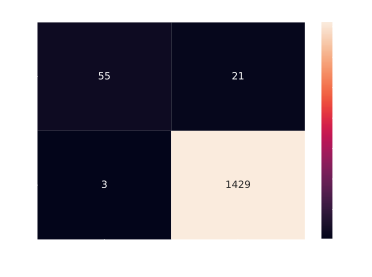

TPR: 0.9482758620689655 FPR: 0.014482758620689656 FNR: 0.05172413793103448 TNR: 0.9855172413793103


In [47]:
cm = confusion_matrix(y_true, y_pred)
tp, fp = cm[0]
fn, tn = cm[1]
fpr = fp / (tn + fp)
tpr = tp / (tp + fn)
fnr = fn / (tp + fn)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix '); 
ax.xaxis.set_ticklabels(['Bad', 'Good']); ax.yaxis.set_ticklabels(['Bad', 'Good']);
plt.show()
print("TPR:", tpr, "FPR:", fpr, "FNR:", fnr, "TNR:", (1-fpr))